In [77]:
from dask_ml.model_selection import HyperbandSearchCV
from dask_ml.wrappers import ParallelPostFit
from dask.distributed import Client
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.svm import SVC
from dask import dataframe as dd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import re
from nltk.stem import WordNetLemmatizer
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from ray.util.joblib import register_ray  


In [54]:
pos = pd.read_csv('./data/possitive_case.csv')
neg = pd.read_csv('./data/negative_case.csv')

In [55]:
neg_columns = ['Unnamed: 0','marketplace','star_rating','helpful_votes','total_votes','verified_purchase','review_headline','review_date','product_title']

In [56]:
neg_reviews_df = neg.drop(columns=neg_columns)

In [57]:
pos['Status'] = 1

In [58]:
pos_reviews_df = pos.drop(columns=neg_columns)

In [59]:
join = [pos_reviews_df,neg_reviews_df]

In [60]:
joined = pd.concat(join)

In [61]:
joined = joined.dropna()

In [62]:
text, status = list(joined['review_body']), list(joined['Status'])

In [63]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

Url_Pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
User_Pattern = '@[^\s]+'
Alph_Num_Pattern = "[^a-zA-Z0-9]"
Repeat_Pattern = r"(.)\1\1+"
Replace_Pattern = r"\1\1"

def process_words(text):
    processed_text = []
    wordLemm = WordNetLemmatizer()
    for review in text:
        review = re.sub(Alph_Num_Pattern, ' ', review)
        review = review.lower()
        review = re.sub(Url_Pattern, 'Url', review)
        for emoji in emojis.keys():
            review = review.replace(emoji, emojis[emoji])
        review = re.sub(User_Pattern, 'User', review)
        review = re.sub(Repeat_Pattern, Replace_Pattern, review)
        review_words = ''
        for word in review.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                review_words += (word+' ')
                
        processed_text.append(review_words)
    return processed_text
    

In [64]:
t = time.time()
processedtext = process_words(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 136 seconds


In [66]:
X_train, X_test, y_train, y_test = train_test_split(text, status,
                                                    test_size = 0.2, random_state = 0,shuffle=True)
print(f'Data Split done.')

Data Split done.


In [67]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=400000)
X_train = vectoriser.fit_transform(X_train)
X_test = vectoriser.transform(X_test)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  400000


In [70]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     31484
           1       0.75      0.75      0.75     30777

    accuracy                           0.75     62261
   macro avg       0.75      0.75      0.75     62261
weighted avg       0.75      0.75      0.75     62261



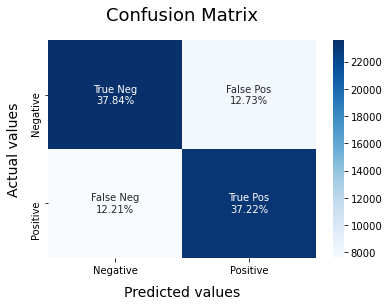

In [84]:
LogModel = LogisticRegression(max_iter=1000)
LogModel.fit(X_train, y_train)
model_Evaluate(LogModel)

In [85]:
client = Client()

/Users/kelvinarellano/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52480 instead
  http_address["port"], self.http_server.port


In [86]:
LogParams = {
    'C':[1.0,10.0,100.0,1000.0],
    'max_iter':[1,10,100,1000], 
    'solver':['lbfgs','liblinear','sag','saga'], 
    'penalty':['l1','l2','elasticnet']
}

In [ ]:
with joblib.parallel_backend(backend='loky', n_jobs=-1,):
    grid_log = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=LogParams,
                 scoring='accuracy',
                 verbose=1,
                 n_jobs=-1)
    results_grid_Log = grid_log.fit(X_train,y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 22] Invalid argument
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 22] Invalid argument
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 22] Invalid argument
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time rece

In [ ]:
grid_Log = GridSearchCV(estimator=LogisticRegression(),
                    param_grid=LogParams,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

result_grid_SVC = grid_Log.fit(X_train, y_train)

In [ ]:
grid_search = GridSearchCV(estimator, param_grid, verbose=2, cv=2)
grid_search.fit(X, y)